# T4: Impact of Zero Location on System Model

In [2]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

print('Basic file found')
%run basic_material.py

from control.matlab import tf,step, tf2ss, ss2tf, bode, ss, lsim
from scipy.signal import residue

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found


# Impact of Sensing Choice on zero location

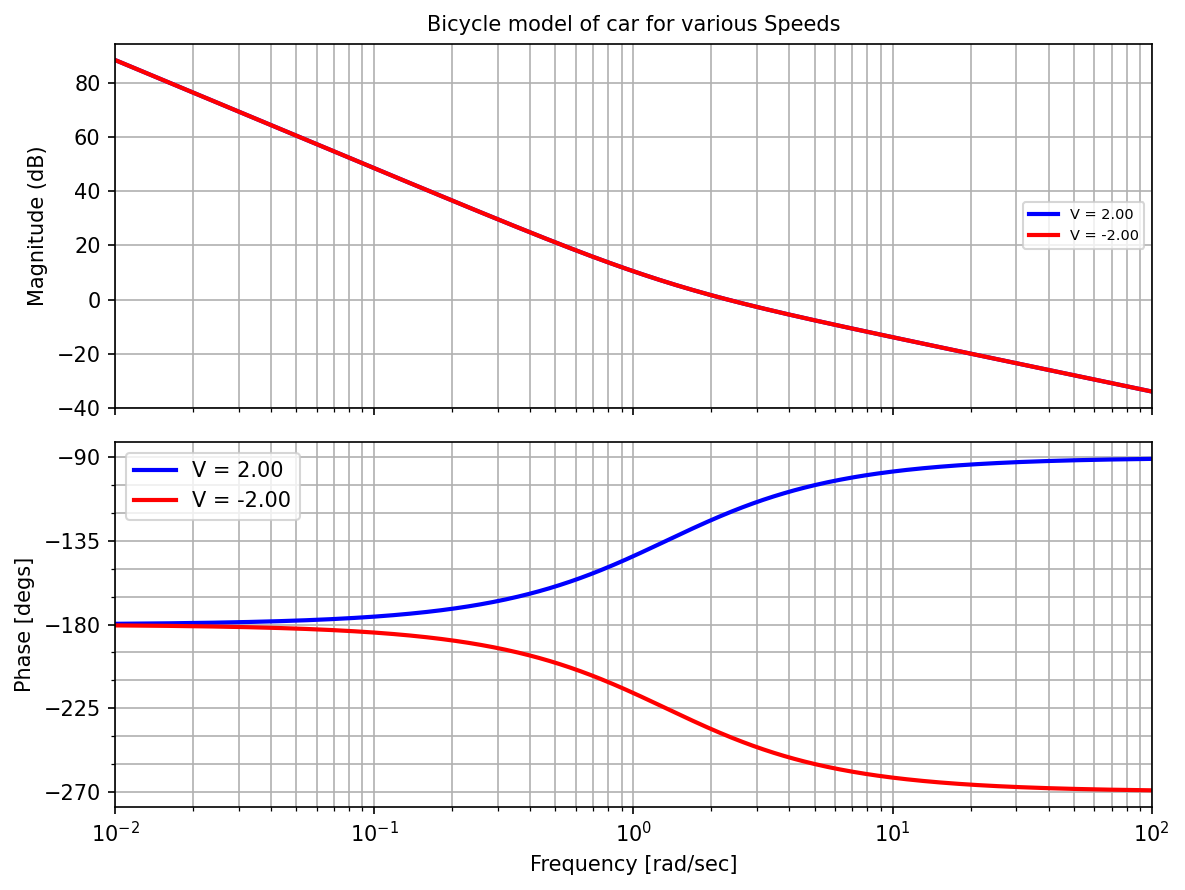

In [3]:
# Bicycle model of car
V0 = 2 # baseline speed
V = [V0, -V0]
b = 1.5 # between axles
s = tf('s')
#L = np.array([0.1*b, 2*b, -0.25*b])
L = b

P = {}
X = {}
Y = {}
Tf = 5
Td = 1
t = np.linspace(0,Tf,1000)

Udoublet = np.zeros_like(t)
Udoublet[t <= 1+2*Td] = -1
Udoublet[t <= 1+Td] = 1
Udoublet[t <= 1] = 0

fig, ax = plt.subplots(2,1,figsize=(8, 6),dpi=150,sharex = True)

for kk,v in enumerate(V):
    P[v] = v/b*(v+L*s)/s**2
    gain, phase, w = bode(P[v], logspace(-2,2,500),label='V = {:3.2f}'.format(v),color=colors[kk])
    yout, T, xout = lsim(P[v],U=Udoublet,T=t)
    Y[v] = yout
    X[v] = T*v
    
ax[1].set_xlabel("Frequency [rad/sec]")
ax[1].set_ylabel("Phase [degs]")

ax[0].set_ylabel("Magnitude (dB)")
ax[0].set_title("Bicycle model of car for various Speeds")
plt.legend()
savefig("./figs/BM_Ex1.pdf", dpi=600)
plt.show()


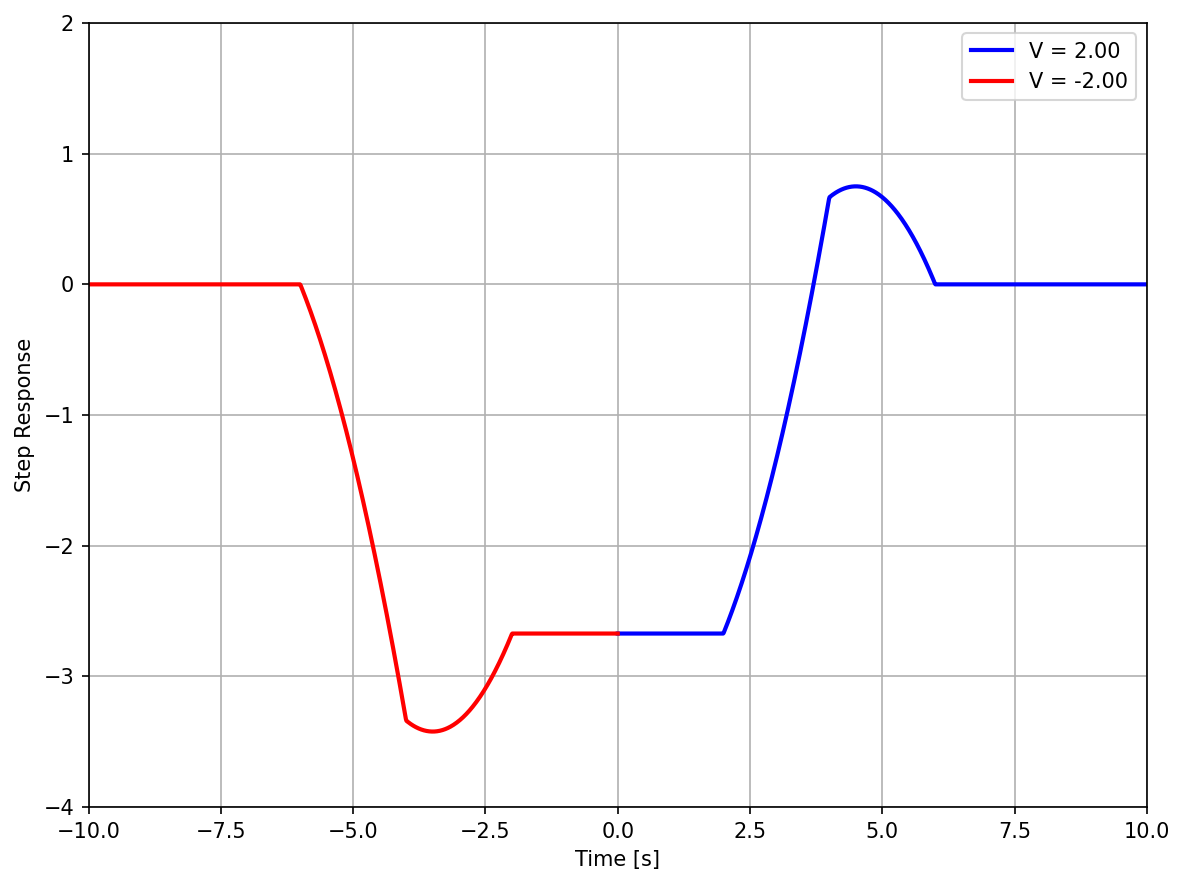

In [4]:
fig, ax = plt.subplots(1,figsize=(8, 6),dpi=150,sharex = True)
for kk,v in enumerate(V):
    plt.plot(X[v],Y[v]-Y[v][-1],label='V = {:3.2f}'.format(v),color=colors[kk])
plt.ylim(-4,2)
plt.xlim(-10,10)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Step Response")
savefig("./figs/BM_Ex1a.pdf", dpi=600)
plt.show()

# Second Order System Step Response with Varying Zero Location

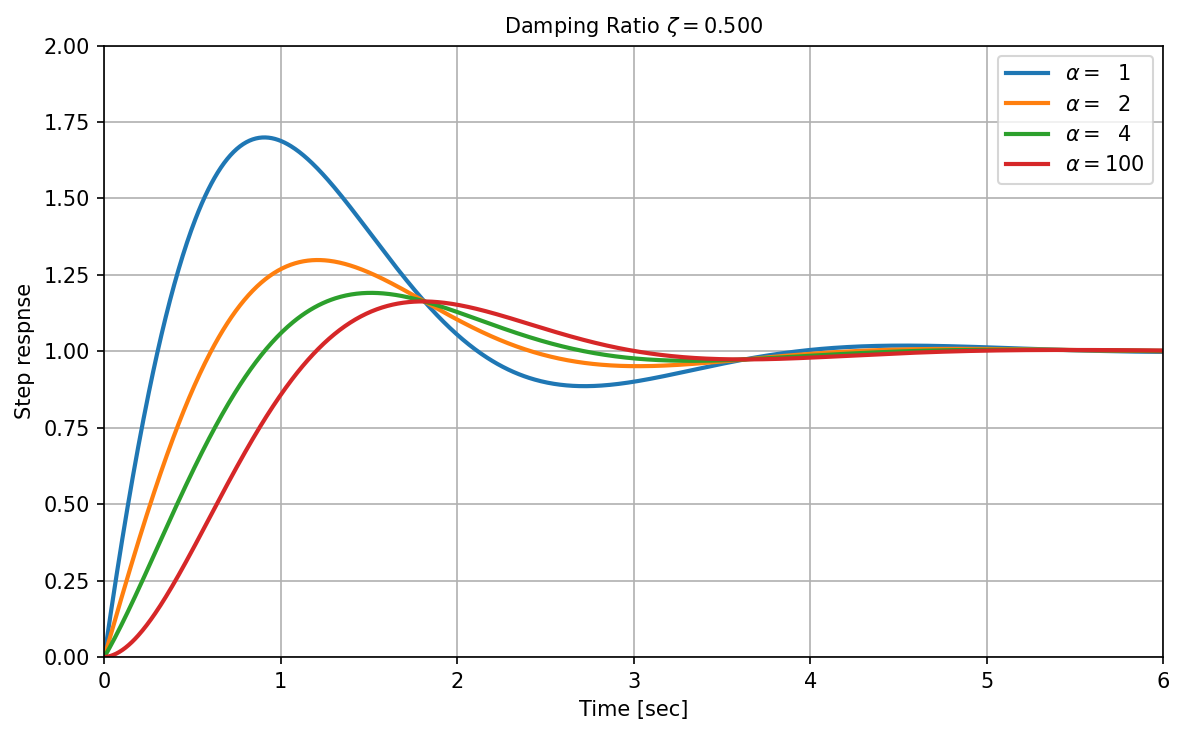

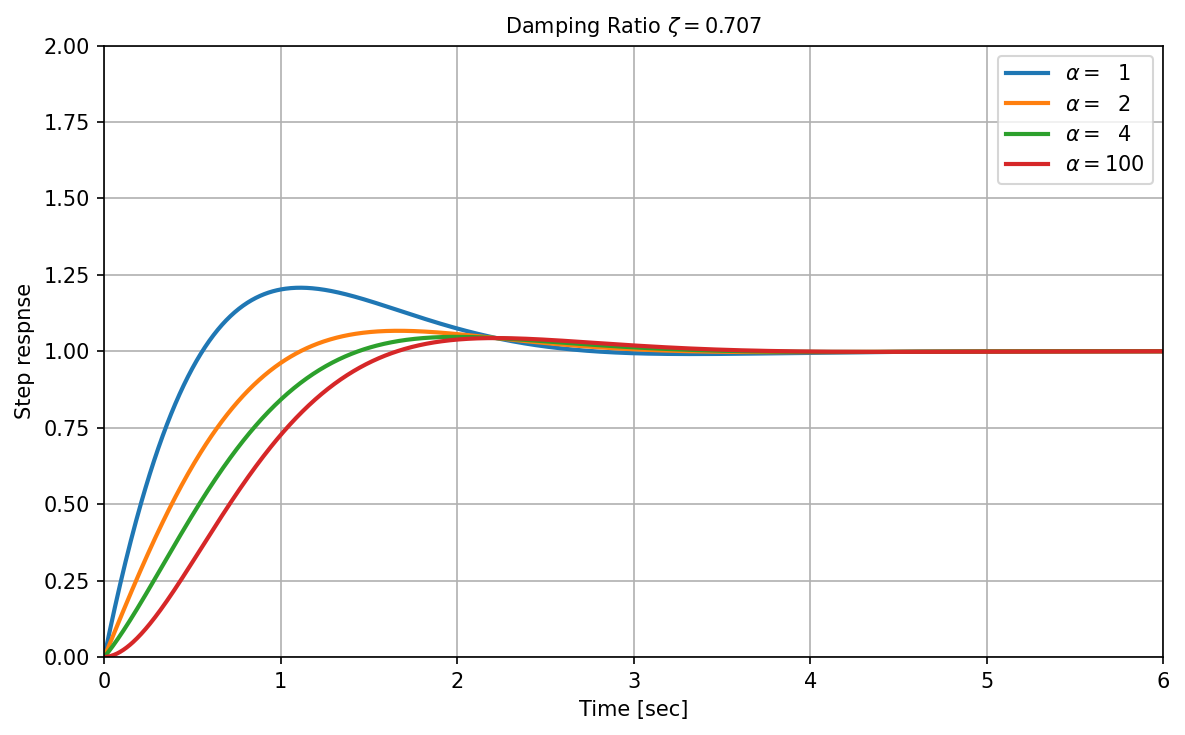

In [5]:
wn = 2
tt = np.linspace(0,6,1000)

for zeta in np.array([0.5, 1/np.sqrt(2)]):
    wd = wn * np.sqrt(1-zeta**2)
    fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,sharex = True)
    for alpha in np.array([1,2,4,100]):
        coef = (alpha*zeta**2 - 1)/alpha/zeta/np.sqrt(1-zeta**2)
        y = 1 - np.exp(-zeta*wn*tt)*(np.cos(wd * tt) + np.sin(wd *tt) * coef)
        plt.plot(tt,y,label=r'$\alpha=${:3.0f}'.format(alpha))
    plt.title("Damping Ratio $\zeta=${:4.3f}".format(zeta))
    plt.legend()
    plt.xlabel("Time [sec]")
    plt.ylabel("Step respnse")
    plt.ylim(0,2)
    savefig("./figs/Zeros_Ex_"+str(round(zeta,3))+".pdf", dpi=600)
    plt.show()

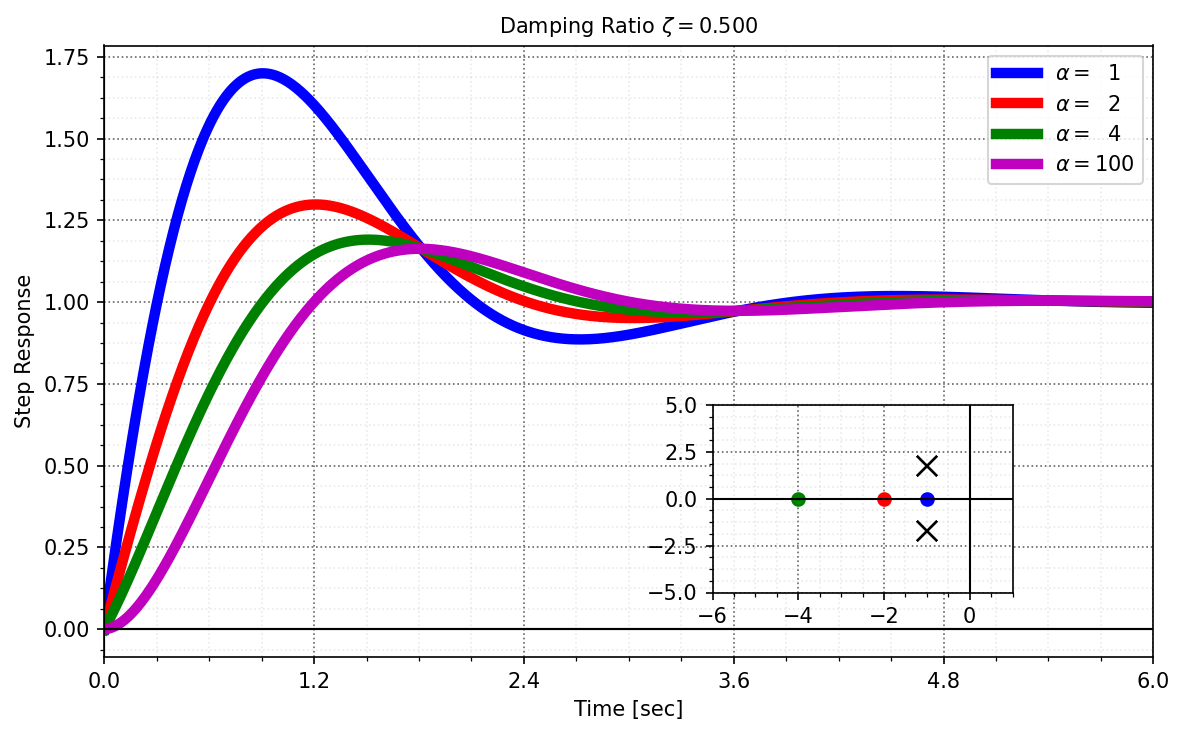

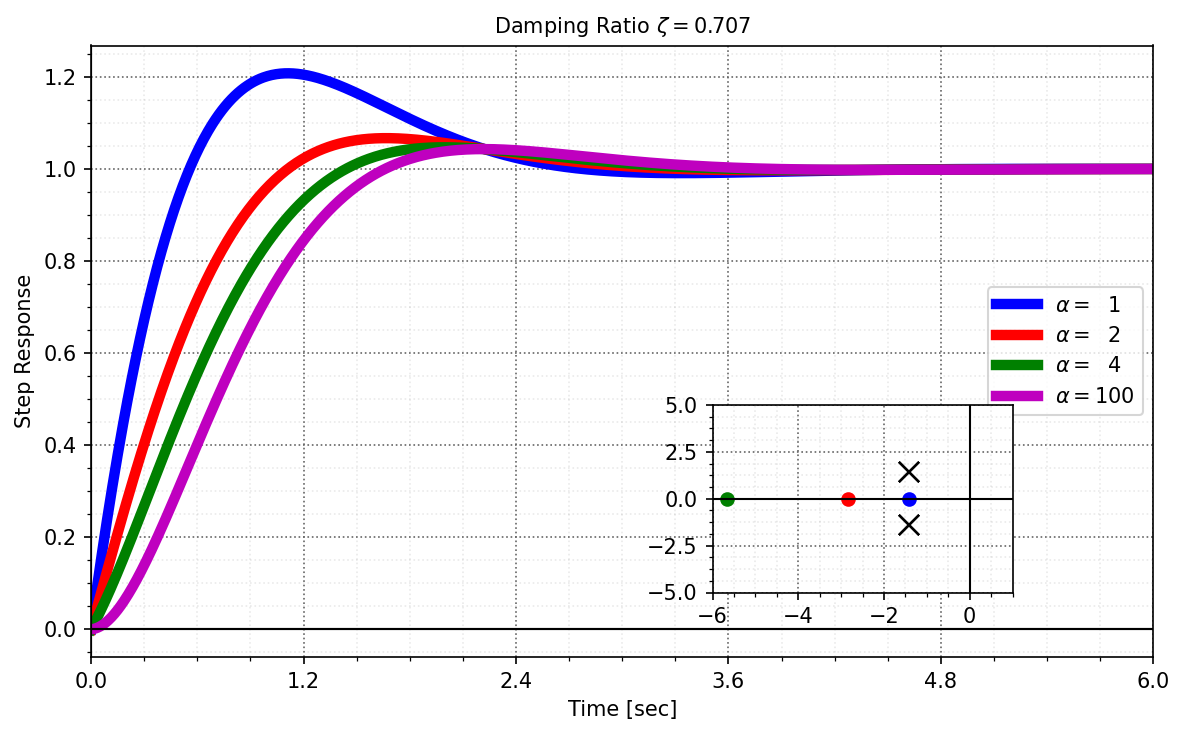

In [6]:
# Lecture 4-20
wn = 2
compare = False
color_list = ['b','r','g','m','c','y']

tt = np.linspace(0,6,1000)
for zeta in np.array([0.5, 1/np.sqrt(2)]):
    fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,sharex = True)
    plt.title("Damping Ratio $\zeta=${:4.3f}".format(zeta))
    plt.xlabel("Time [sec]")
    plt.ylabel("Step Response")
    wd = wn * np.sqrt(1-zeta**2)

    left, bottom, width, height = [0.6, 0.2, 0.25, 0.25]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.figure.set_facecolor('w')

    for kk,alp in enumerate(np.array([1,2,4,100])):
        G = tf((wn/(alp*zeta), wn**2), (1, 2*zeta*wn, wn**2))
        [yy,tt] = step(G,tt)
        ax.plot(tt,yy,label=r'$\alpha=${:3.0f}'.format(alp),lw=5, color=color_list[kk])

        if compare:
            coef = (alp*zeta**2 - 1)/(alp * zeta *np.sqrt(1-zeta**2))
            y = 1 - np.exp(-zeta*wn*tt)*(np.cos(wd * tt) + coef * np.sin(wd * tt))
            plt.plot(tt,y,'--',label=r'$\alpha=${:3.0f}'.format(alp))
            ax.text(2,.4,'Predicted dashed and simulated solid')
            
        ax2.plot(np.real(G.poles()),np.imag(G.poles()), 'x', ms=10,color='k')
        ax2.plot(np.real(G.zeros()),np.imag(G.zeros()), 'o', ms=6,color=color_list[kk])
        
    ax.legend()
    plt.ylim((0,1.8))
    nicegrid(ax)
    
    ax2.set_xlim((-6,1))
    ax2.set_ylim((-5,5))
    nicegrid(ax,6)
    nicegrid(ax2,-6)
    
    savefig("./figs/Zeros_Ex_"+str(round(zeta,3))+".pdf", dpi=600)
    plt.show()

## VDV prediction of impact of adding a zero (section 5.3)

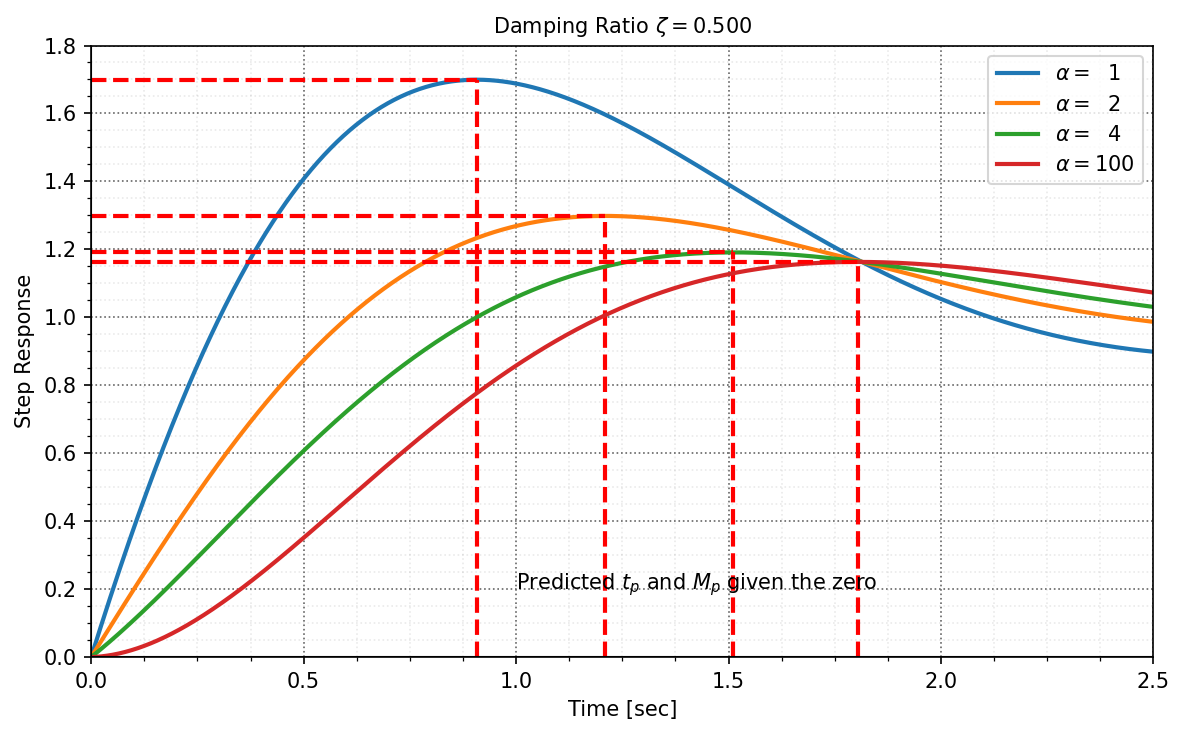

In [7]:
'''
if alpha = angle between line from zero to complex pole 
then

tp = (pi - alpha)/omega_d

Mp = K exp(-(pi - alpha) sigma/omega_d)

where K = A/z and A^ = (sigma-z)^2 + omega_d^2

'''
wn = 2
zeta = 0.5
sigma = zeta*wn
wd = wn*np.sqrt(1-zeta**2)

def tp_mp_pred(zero):
    try:
        alpha = np.arctan(wd/(zero-sigma))
    except:
        alpha = np.pi/2

    tp = (np.pi)/wd
    Mp = np.exp(-np.pi * sigma/wd)
    tp_with_zero = (np.pi - alpha)/wd
    Mp_with_zero = np.sqrt((sigma-zero)**2 + wd**2)/zero * np.exp(-(np.pi - alpha) * sigma/wd)
    return (tp, tp_with_zero, Mp, Mp_with_zero)

tt = np.linspace(0,2.5,1000)

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,sharex = True)
plt.title("Damping Ratio $\zeta=${:4.3f}".format(zeta))
plt.xlabel("Time [sec]")
plt.ylabel("Step Response")
wd = wn * np.sqrt(1-zeta**2)
for alp in np.array([1,2,4,100]):
    z = alp*zeta*wn
    tp, tp_with_zero, Mp, Mp_with_zero = tp_mp_pred(z)
    G = tf((wn/(alp*zeta), wn**2), (1, 2*zeta*wn, wn**2))
    [yy,tt] = step(G,tt)
    plt.plot(tt,yy,label=r'$\alpha=${:3.0f}'.format(alp),lw=2)

    coef = (alp*zeta**2 - 1)/(alp * zeta *np.sqrt(1-zeta**2))
    plt.axvline(x = tp_with_zero,ymax=(1 + Mp_with_zero)/1.8,c='r',ls='--')
    plt.axhline(y = 1 + Mp_with_zero,xmax=tp_with_zero/2.5,c='r',ls='--')

plt.legend()
plt.text(1,.2,r'Predicted $t_p$ and $M_p$ given the zero',c='k')
plt.ylim((0,1.8))
nicegrid(ax,6)
savefig("./figs/Zeros_Ex_"+str(round(zeta,3))+"_pred.pdf", dpi=600)
plt.show()

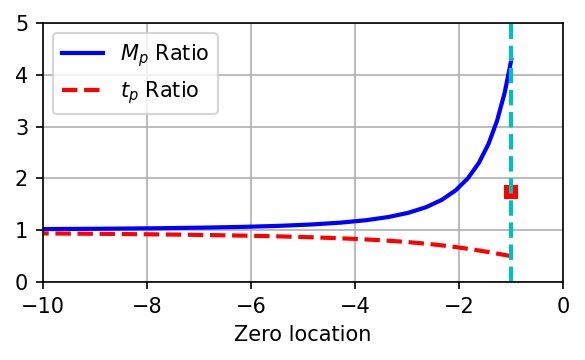

./figs/Zeros_Ex_0.5_pred2.pdf


In [8]:
fig, ax = plt.subplots(1,figsize=(4, 2.5),dpi=150,sharex = True)
store_Mp =[]
store_tp =[]
A = np.logspace(0,1,20)
for alp in A:
    z = alp*zeta*wn
    tp, tp_with_zero, Mp, Mp_with_zero = tp_mp_pred(z)
    store_Mp = np.append(store_Mp,Mp_with_zero/Mp)
    store_tp = np.append(store_tp,tp_with_zero/tp)

ax.plot(-A*zeta*wn,store_Mp,'b-',label=r'$M_p$ Ratio')
ax.plot(-A*zeta*wn,store_tp,'r--',label=r'$t_p$ Ratio')
ax.plot(-zeta*wn,wn*np.sqrt(1-zeta**2),'rs')
ax.axvline(x=-zeta*wn,c='c',ls='--')
ax.set_ylim(0,5)
ax.set_xlim(-10,0)
ax.set_xlabel('Zero location')
ax.legend()
savefig("./figs/Zeros_Ex_"+str(round(zeta,3))+"_pred2.pdf", dpi=600)
plt.show()
print("./figs/Zeros_Ex_"+str(round(zeta,3))+"_pred2.pdf")

## Lecture 4-20

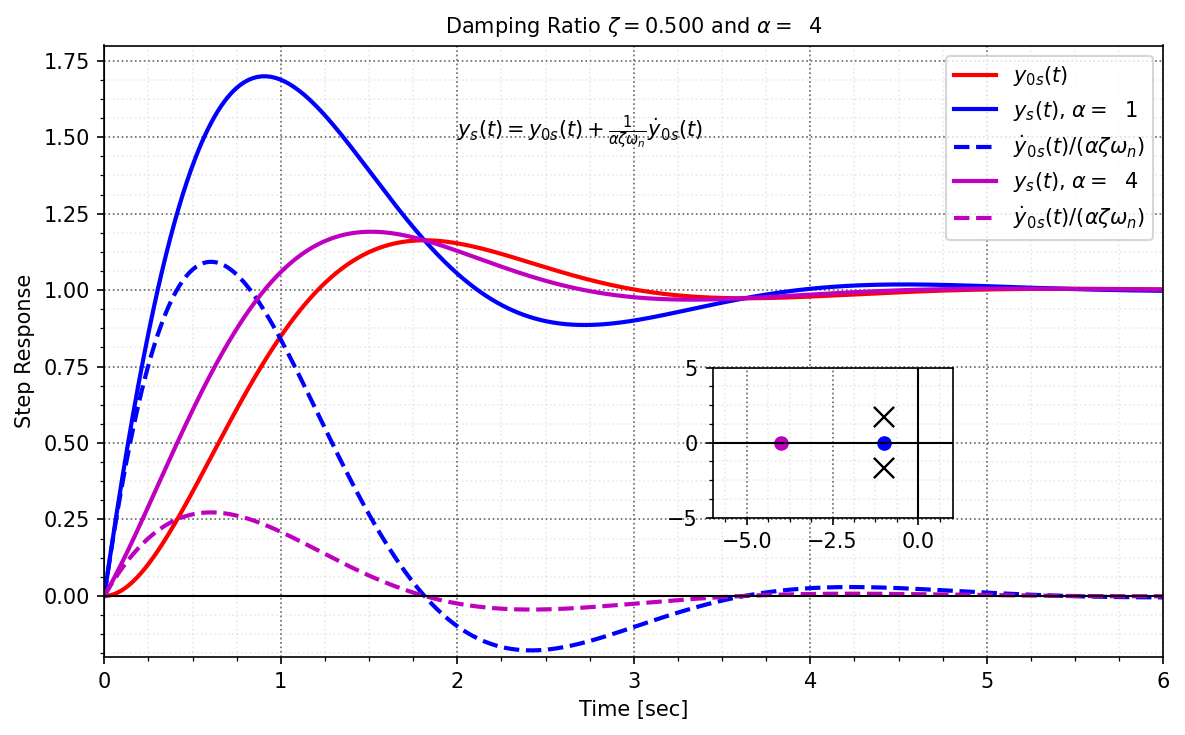

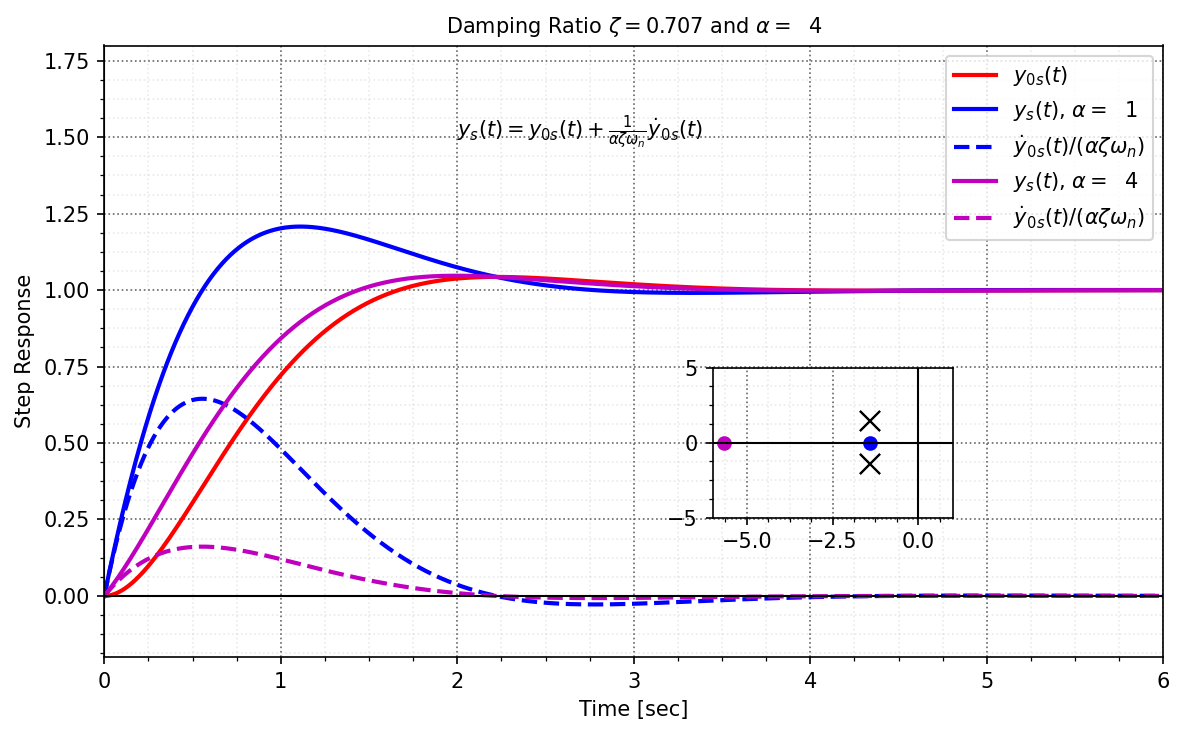

In [9]:
wn = 2
tt = np.linspace(0,6,1000)
color_list = ['b','m']
for zeta in np.array([0.5, 1/np.sqrt(2)]):
    fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,sharex = True)
    plt.xlabel("Time [sec]")
    plt.ylabel("Step Response")
    left, bottom, width, height = [0.6, 0.3, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.figure.set_facecolor('w')
    G0 = tf((0, wn**2), (1, 2*zeta*wn, wn**2))
    [yy0,tt] = step(G0,tt)
    for alp in np.array([1,4]):
        G = tf((wn/(alp*zeta), wn**2), (1, 2*zeta*wn, wn**2))
        G0d = tf((wn**2/(alp*zeta*wn), 0), (1, 2*zeta*wn, wn**2))
        [yy,tt] = step(G,tt)
        [yy0d,tt] = step(G0d,tt)
        if alp == 1:
            kk = 0
            ax.plot(tt,yy0,'r-',label=r'$y_{0s}(t)$',lw=2)
            ax.plot(tt,yy,'b-',label=r'$y_s(t)$, $\alpha=${:3.0f}'.format(alp),lw=2)
            ax.plot(tt,yy0d,'b--',label=r'$\dot y_{0s}(t)/(\alpha\zeta\omega_n)$')
        else:
            kk = 1
            ax.plot(tt,yy,'m-',label=r'$y_s(t)$, $\alpha=${:3.0f}'.format(alp),lw=2)
            ax.plot(tt,yy0d,'m--',label=r'$\dot y_{0s}(t)/(\alpha\zeta\omega_n)$')
        ax.set_title(r"Damping Ratio $\zeta=${:4.3f} and $\alpha=${:3.0f}".format(zeta,alp))

        ax2.plot(np.real(G.poles()),np.imag(G.poles()), 'x', ms=10,color='k')
        ax2.plot(np.real(G.zeros()),np.imag(G.zeros()), 'o', ms=6,color=color_list[kk])
        ax2.set_xlim((-6,1))
        ax2.set_ylim((-5,5))

    ax.text(2,1.5,r'$y_s(t) = y_{0s}(t) + \frac{1}{\alpha\zeta\omega_n} \dot y_{0s}(t)$')
    ax.legend()
    nicegrid(ax)
    nicegrid(ax2)
    ax.set_ylim((-0.2,1.8))
    savefig("./figs/Zeros_Ex2_"+str(round(zeta,3))+".pdf", dpi=600)
    plt.show()

## Lecture 4-20

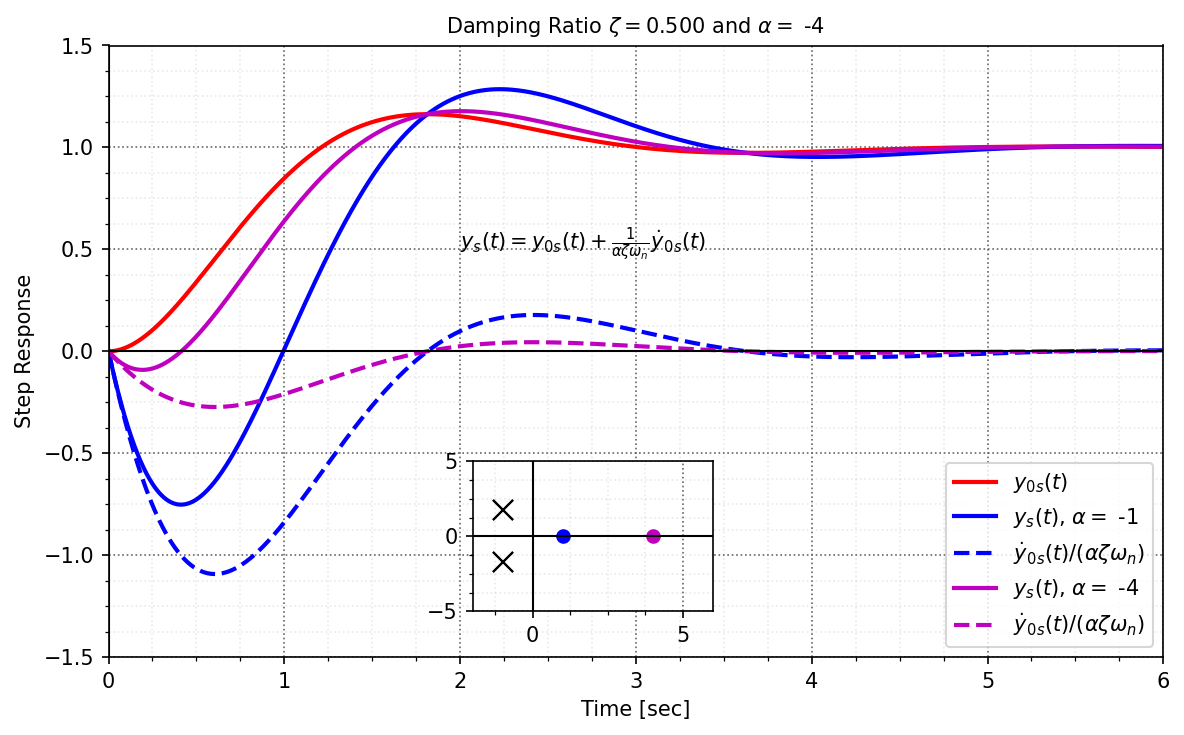

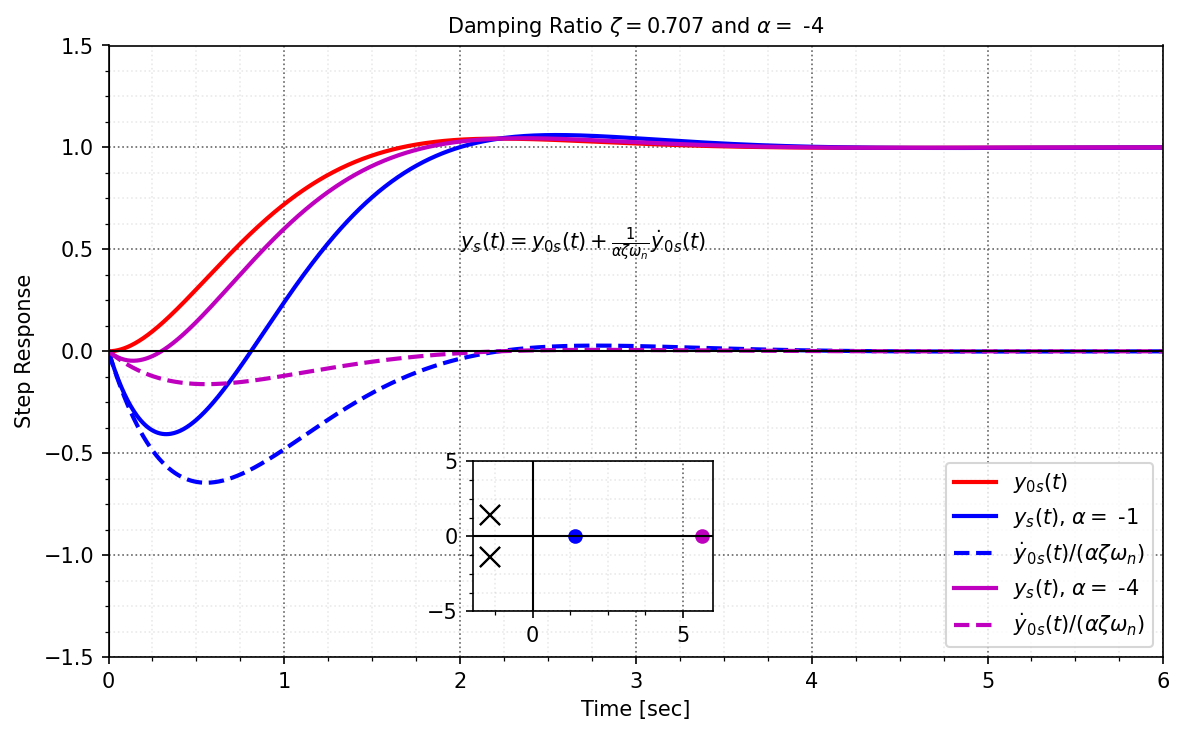

In [10]:
wn = 2
tt = np.linspace(0,6,1000)
for zeta in np.array([0.5, 1/np.sqrt(2)]):
    fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,sharex = True)
    plt.xlabel("Time [sec]")
    plt.ylabel("Step Response")
    left, bottom, width, height = [0.4, 0.175, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.figure.set_facecolor('w')
    for alp in np.array([-1,-4]):
        G = tf((wn/(alp*zeta), wn**2), (1, 2*zeta*wn, wn**2))
        G0 = tf((0, wn**2), (1, 2*zeta*wn, wn**2))
        G0d = tf((wn**2/(alp*zeta*wn), 0), (1, 2*zeta*wn, wn**2))
        [yy,tt] = step(G,tt)
        [yy0,tt] = step(G0,tt)
        [yy0d,tt] = step(G0d,tt)
        if alp > -4:
            kk = 0
            ax.plot(tt,yy0,'r-',label=r'$y_{0s}(t)$',lw=2)
            ax.plot(tt,yy,'b',label=r'$y_s(t)$, $\alpha=${:3.0f}'.format(alp),lw=2)
            ax.plot(tt,yy0d,'b--',label=r'$\dot y_{0s}(t)/(\alpha\zeta\omega_n)$')
        else:
            kk = 1
            ax.plot(tt,yy,'m-',label=r'$y_s(t)$, $\alpha=${:3.0f}'.format(alp),lw=2)
            ax.plot(tt,yy0d,'m--',label=r'$\dot y_{0s}(t)/(\alpha\zeta\omega_n)$')
        ax.set_title(r"Damping Ratio $\zeta=${:4.3f} and $\alpha=${:3.0f}".format(zeta,alp))

        ax2.plot(np.real(G.poles()),np.imag(G.poles()), 'x', ms=10,color='k')
        ax2.plot(np.real(G.zeros()),np.imag(G.zeros()), 'o', ms=6,color=color_list[kk])
        ax2.set_xlim((-2,6))
        ax2.set_ylim((-5,5))

    ax.text(2,.5,r'$y_s(t) = y_{0s}(t) + \frac{1}{\alpha\zeta\omega_n} \dot y_{0s}(t)$')
    ax.legend()
    nicegrid(ax)
    nicegrid(ax2)
    ax.set_ylim((-1.5,1.5))
    savefig("./figs/Zeros_Ex3_"+str(round(zeta,3))+".pdf", dpi=600)
    plt.show()

## Lecture 4-22

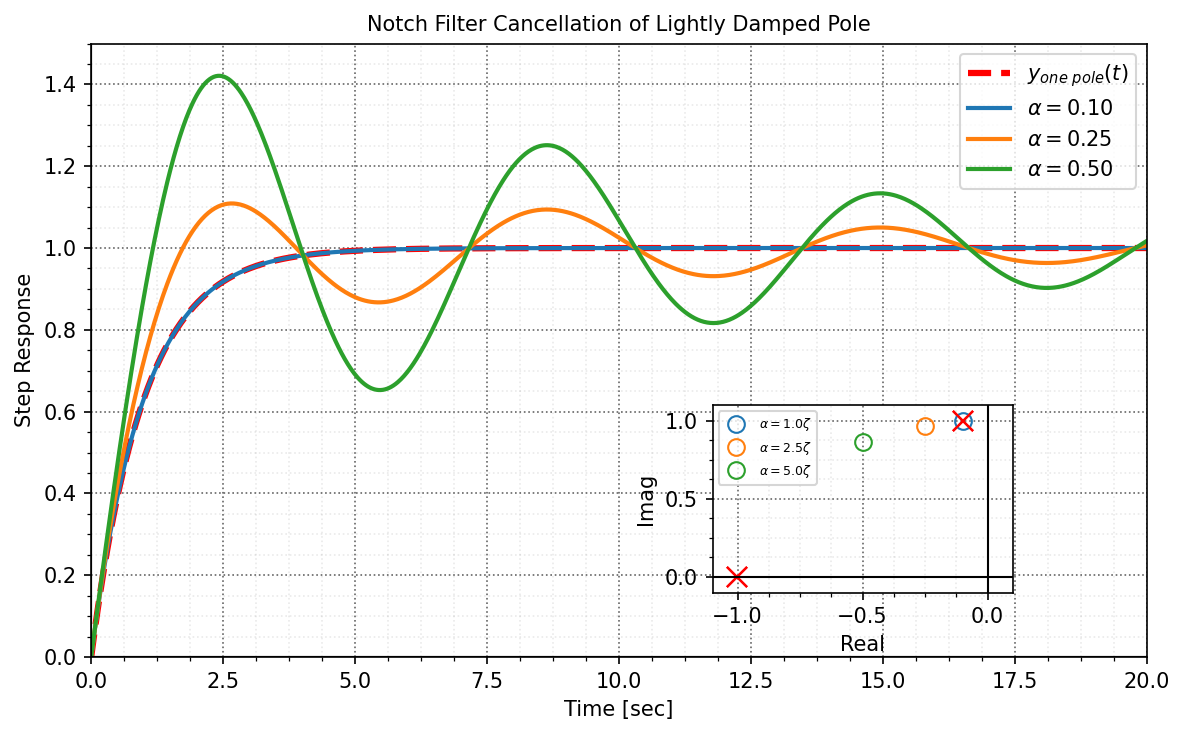

In [11]:
zeta = 0.1
wn = 1
tt = np.linspace(0,20,1000)
fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,sharex = True)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Step Response")
nicegrid(ax)

left, bottom, width, height = [0.6, 0.2, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.figure.set_facecolor('w')
ax2.set_xlabel("Real")
ax2.set_ylabel("Imag")

Ga = tf((1), (1,1))
G_system = tf((wn**2), (1, 2*zeta*wn, wn**2))
[yya,tt] = step(Ga,tt)
ax.plot(tt,yya,'r--',label=r'$y_{one~pole}(t)$',lw=3)

for alp in np.array([0.1, 0.25, 0.5]):
    G_notch = tf((1, 2*alp*wn, wn**2), (wn**2))
    G = Ga * G_system * G_notch
    [yy,tt] = step(G,tt)
    ax.plot(tt,yy,label=r'$\alpha={:3.2f}$'.format(alp))

    ax2.plot(np.real(G.poles()),np.imag(G.poles()), 'x', ms=10, color='red')
    ax2.plot(np.real(G.zeros()),np.imag(G.zeros()), 'o', markerfacecolor='none', ms=8, label=r'$\alpha={:2.1f}\zeta$'.format(alp/zeta))
    
ax.set_title(r"Notch Filter Cancellation of Lightly Damped Pole")
ax.legend()
ax2.legend(prop = { "size": 6 })
ax.set_ylim((0,1.5))
ax2.set_xlim((-1.1,0.1))
ax2.set_ylim((-0.1,1.1))
nicegrid(ax)
nicegrid(ax2)
savefig("./figs/Zeros_Ex4_"+str(round(zeta,3))+".pdf", dpi=600)
plt.show()

## Lecture 4-22 - Add pole

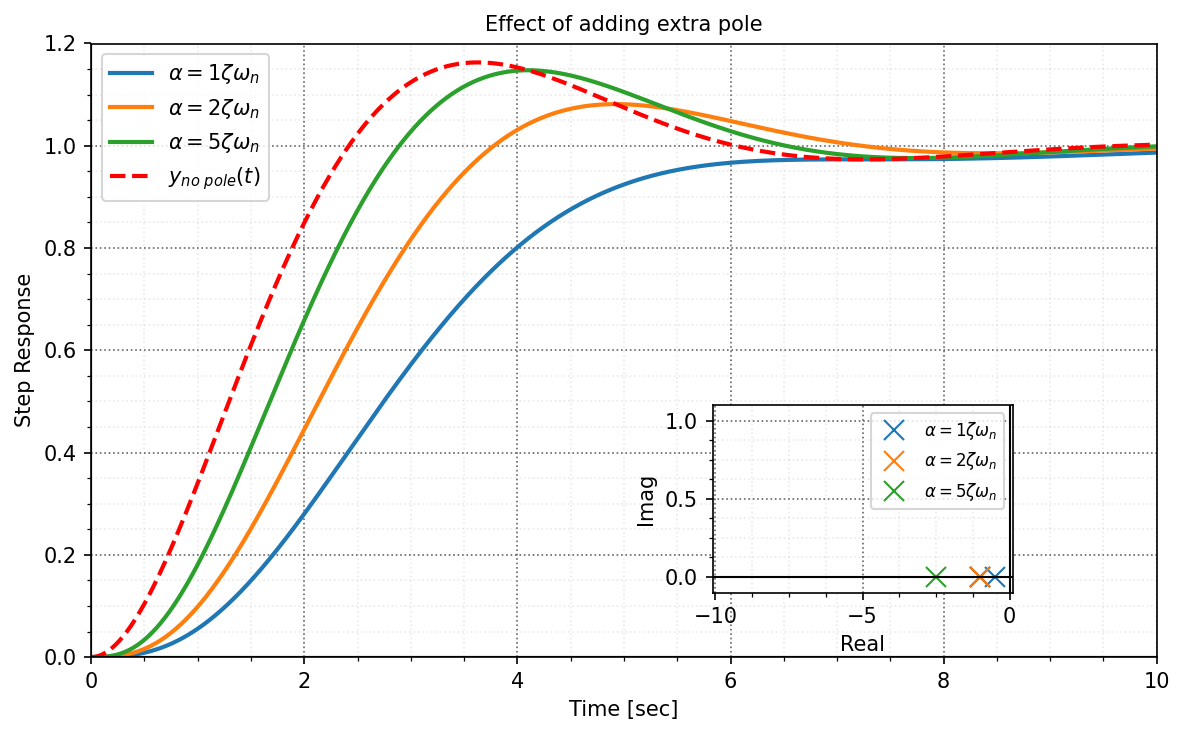

In [12]:
zeta = 0.5
wn = 1
tt = np.linspace(0,10,1000)
fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,sharex = True)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Step Response")

left, bottom, width, height = [0.6, 0.2, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.figure.set_facecolor('w')
nicegrid(ax)
ax2.set_xlabel("Real")
ax2.set_ylabel("Imag")
ax2.plot(np.real(Ga.poles()),np.imag(Ga.poles()), 'kx', ms=10)

Ga = tf((wn**2), (1, 2*zeta*wn, wn**2))
for alp in np.array([1,2,5]):
    Gp = tf(1, (1/(alp*zeta*wn),1))
    G = Ga*Gp
    [yy,tt] = step(G,tt)
    ax.plot(tt,yy,label=r'$\alpha={:3.0f}\zeta\omega_n$'.format(alp))

    ax2.plot(np.real(Gp.poles()),np.imag(Gp.poles()), 'x', ms=10, label=r'$\alpha={:2.0f}\zeta\omega_n$'.format(alp))
    
[yya,tt] = step(Ga,tt)
ax.plot(tt,yya,'r--',label=r'$y_{no~pole}(t)$')
ax.set_title(r"Effect of adding extra pole")
ax.legend()
nicegrid(ax)
nicegrid(ax2)
ax2.legend(prop = { "size": 8 })
ax.set_ylim((0,1.2))
ax2.set_xlim((-10.1,0.1))
ax2.set_ylim((-0.1,1.1))
savefig("./figs/Zeros_Ex5_"+str(round(zeta,3))+".pdf", dpi=600)
plt.show()